In [51]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [52]:
#Read data set
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Store train data size
ntrain = data.shape[0]

print(f"data shape {data.shape} ")
print(f"test shape {test.shape} ")

#Combine both data for smooth data cleaning
all_data = pd.concat([data, test], axis=0).reset_index(drop=True)

#remove target label from combibed data 
all_data = all_data.drop("Survived", axis=1)

print(f"all_data shape {all_data.shape}")

data shape (891, 12) 
test shape (418, 11) 
all_data shape (1309, 11)


In [53]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [54]:
print(data.describe(include="all"))

        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare 

In [55]:
print("Proportion of Survived", data["Survived"].value_counts())

Proportion of Survived Survived
0    549
1    342
Name: count, dtype: int64


In [56]:
#Check missing values
missing_columns  = (all_data.isnull().sum() /len(all_data)).sort_values(ascending=False)
print(f"Before removing high missing rate \n {missing_columns}")
print("-"*40)

#Remove colums("Cabin") in wchih more than 40% of data is missing value
#Remove "Ticket" column because it doesn't include any info   
try:
    all_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)
except KeyError:
    print("Columns already dropped.")
print(f"After removing high missing rate \n {all_data.isnull().sum().sort_values(ascending=False)}")

Before removing high missing rate 
 Cabin          0.774637
Age            0.200917
Embarked       0.001528
Fare           0.000764
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
dtype: float64
----------------------------------------
After removing high missing rate 
 Age            263
Embarked         2
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
dtype: int64


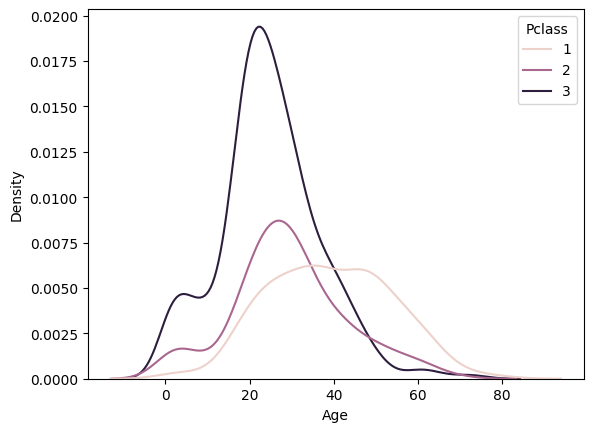

Number of missing valued after filling it 0


In [57]:
#About age column

#Visualize
sns.kdeplot(data= all_data, x= "Age", hue="Pclass")
plt.show()

#It shows that there is a age-mean diffrence between Plcass

#Fill age missing values by Plclass
all_data["Age"] = all_data.groupby("Pclass")["Age"].transform(lambda x:x.fillna(x.mean()))
print(f"Number of missing valued after filling it {all_data["Age"].isna().sum()}")

#Fill "Embarked" missing values by mode
all_data["Embarked"] = all_data["Embarked"].fillna(all_data["Embarked"].mode()[0])

#Fill "Fare" missing values by median
all_data["Fare"] = all_data["Fare"].fillna(all_data["Fare"].median())


In [58]:
#Add new features
#"FamilySize" denotes how mamy relatives there were in Titanic 
all_data["FamilySize"] = all_data["SibSp"] + all_data["Parch"] + 1

#"IsAlone" denotes if that passernger was alone or not (yes/1 is alone) 
all_data["IsAlone"] = 1 
all_data["IsAlone"].loc[all_data["FamilySize"] >1] = 0

#"Title" denotes "Mr","Mrs" etc 
all_data["Title"] = all_data["Name"].str.split(",", expand=True)[1].str.split(".", expand=True)[0]

C:\Users\thosa\AppData\Local\Temp\ipykernel_14852\4040335376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["IsAlone"].loc[all_data["FamilySize"] >1] = 0


In [59]:
#Chage small portion of titile to "others"
title_names  = (all_data["Title"].value_counts() < 10)
all_data["Title"] = all_data["Title"].apply(lambda x: "Misc" if title_names.loc[x] == True else x)
print(all_data["Title"].value_counts())

Title
 Mr        757
 Miss      260
 Mrs       197
 Master     61
Misc        34
Name: count, dtype: int64


In [60]:
#categorical data
categorical_data = all_data.select_dtypes("object")

for column in categorical_data.columns:
  contingency_table = pd.crosstab(data["Survived"], categorical_data[column])
  print(column)
  # Chi-Squre test
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  print(f"Chi-square: {chi2}, p-value: {p}")

#The result indicates that　"Plcass"、"Sex","Embarked","Title" are related to "Survived"

Name
Chi-square: 891.0, p-value: 0.484248151973633
Sex
Chi-square: 260.71702016732104, p-value: 1.1973570627755645e-58
Embarked
Chi-square: 25.964452881874784, p-value: 2.3008626481449577e-06
Title
Chi-square: 283.3115089621979, p-value: 4.305036064730923e-60


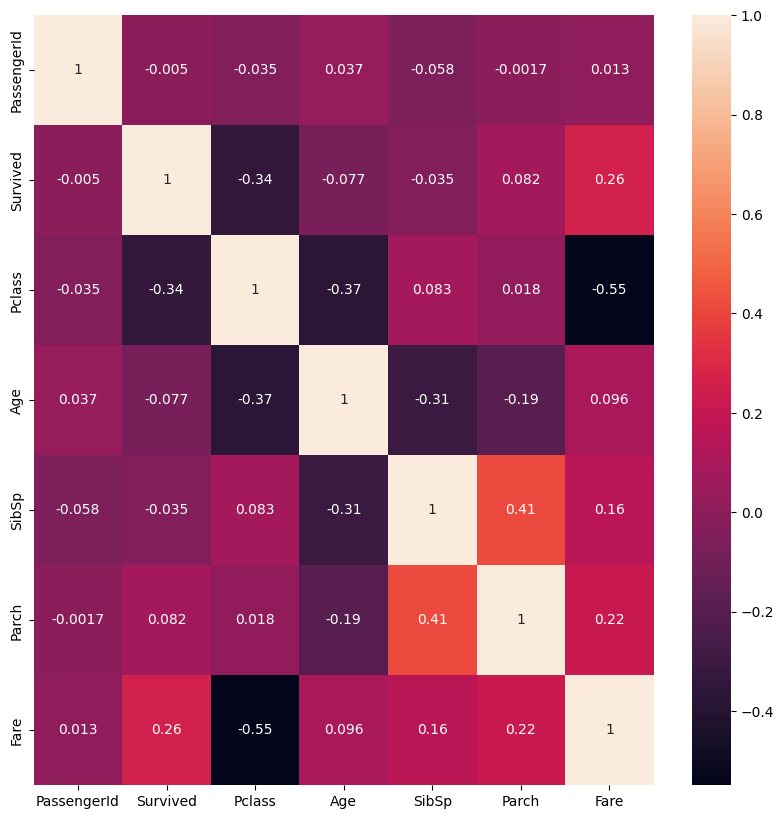

In [61]:
#numerical data 
plt.figure(figsize=(10,10))
numerical_data = data.select_dtypes(np.number)
sns.heatmap(numerical_data.corr(), annot=True)
plt.show()

In [62]:
#Extract essential features
extracted_df = all_data[["PassengerId","Pclass","Sex","Embarked", "FamilySize", "Age","IsAlone", "Title","Fare"]]
print(f"extracted_df {extracted_df.shape}")
print(extracted_df.head())

extracted_df (1309, 9)
   PassengerId  Pclass     Sex Embarked  FamilySize   Age  IsAlone  Title  \
0            1       3    male        S           2  22.0        0     Mr   
1            2       1  female        C           2  38.0        0    Mrs   
2            3       3  female        S           1  26.0        1   Miss   
3            4       1  female        S           2  35.0        0    Mrs   
4            5       3    male        S           1  35.0        1     Mr   

      Fare  
0   7.2500  
1  71.2833  
2   7.9250  
3  53.1000  
4   8.0500  


In [63]:
#Standalized numerical data 
std_extracted_df = extracted_df.copy()
Std = StandardScaler()
std_extracted_df["Age"] = Std.fit_transform(std_extracted_df[["Age"]])
std_extracted_df["Fare"] = Std.fit_transform(std_extracted_df[["Fare"]])
std_extracted_df.head()


,PassengerId,Pclass,Sex,Embarked,FamilySize,Age,IsAlone,Title,Fare
0,1,3,male,S,2,-0.559957,0,Mr,-0.503291
1,2,1,female,C,2,0.659292,0,Mrs,0.734744
2,3,3,female,S,1,-0.255145,1,Miss,-0.490240
3,4,1,female,S,2,0.430683,0,Mrs,0.383183
4,5,3,male,S,1,0.430683,1,Mr,-0.487824


In [64]:
#One-Hot encoding
std_extracted_df = pd.get_dummies(data=std_extracted_df, columns=["Sex","Embarked","Title"])
std_extracted_df.head()

,PassengerId,Pclass,FamilySize,Age,IsAlone,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,1,3,2,-0.559957,0,-0.503291,False,True,False,False,True,False,False,True,False,False
1,2,1,2,0.659292,0,0.734744,True,False,True,False,False,False,False,False,True,False
2,3,3,1,-0.255145,1,-0.490240,True,False,False,False,True,False,True,False,False,False
3,4,1,2,0.430683,0,0.383183,True,False,False,False,True,False,False,False,True,False
4,5,3,1,0.430683,1,-0.487824,False,True,False,False,True,False,False,True,False,False


In [68]:
#Split all_data into train and test data 
train = std_extracted_df[:ntrain]
y = data["Survived"]
train = train.drop("PassengerId", axis=1)

test = std_extracted_df[ntrain:]
PassengerId = test["PassengerId"]
test = test.drop("PassengerId", axis=1)

print(f"train shpae {train.shape}")
print(f"test shpae {test.shape}")

train shpae (891, 15)
test shpae (418, 15)


In [ ]:
#Split train data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [ ]:
#Execute Grid Serach to find better Algorithm and hyper parmeters
models = {
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {'max_depth': [3,4, 5, 10], "min_samples_split":[2,3,4,5],"criterion":["gini","entropy"]}),
    "RandomForest": (RandomForestClassifier(random_state=42), {'max_depth': [3,4, 5, 10],'n_estimators': [10, 50, 100]}),
    "Bagging":(BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4), random_state=42), {"n_estimators":[10,50,100]}),
    "Boosting":(GradientBoostingClassifier(random_state=42), {"n_estimators":[10,50,100], "learning_rate":[0.001, 0.01, 0.1]})
}

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-validation Score: {grid_search.best_score_:.2f}")
    print("-"*40)

#From this execution 
# Model: RandomForest
# Best Parameters: {'max_depth': 5, 'n_estimators': 10}
# Best Cross-validation Score: 0.84
# performed the best 


Model: DecisionTree
  Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
  Best Cross-validation Score: 0.82
----------------------------------------
Model: RandomForest
  Best Parameters: {'max_depth': 5, 'n_estimators': 10}
  Best Cross-validation Score: 0.84
----------------------------------------
Model: Bagging
  Best Parameters: {'n_estimators': 50}
  Best Cross-validation Score: 0.82
----------------------------------------
Model: Boosting
  Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
  Best Cross-validation Score: 0.82
----------------------------------------


In [ ]:
#Built a model by the best pefromance one
model = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)
model.fit(X_train, y_train)
y_pred =model.predict(X_train)
print(f"Final Model Accuracy: {accuracy_score(y_train, y_pred):.2f}")

Final Model Accuracy: 0.85


In [ ]:
#Formatlize result
compare_result = pd.DataFrame({
    'PassengerId': PassengerId,
    'Survived': model.predict(test)
})

# Save it to CSV file
compare_result.to_csv('submission.csv', index=False)